In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip
# !cp glove.6B.100d.txt ./data/

In [2]:
import collections
import numpy as np
import json

import torch
from torch import nn
import torch.nn.functional as F

from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from prepocessing import create_loader
from load_pretrained import load_embeddings

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
train_loader, valid_loader, test_loader, word_to_id, char_to_id, tag_to_id = create_loader(batch_size=64)

Found 17493 unique words (203621 in total)
Found 75 unique characters
Found 10 unique named entity tags


In [12]:
embeddings = load_embeddings(word_to_id)

LOADING PREATRAINED ...
Loaded 400000 pretrained embeddings.


In [17]:
embeddings_dim = embeddings.shape[-1]
embeddings[0] = np.zeros(embeddings_dim)
embeddings = torch.tensor(embeddings).float()

In [91]:
class CNNNERModel(nn.Module):
    
    def __init__(self, char_vocab_size, n_labels, word_embeddings, char_kernels_quantity = 3,
                 embedding_dim=64, model_dim=128, word_kernel=3,
                 word_cnn_layers_quantity=4, padding_idx=0):
        
        super().__init__()
        
        self.word_kernel = word_kernel
        self.embedding_dim = char_kernels_quantity * embedding_dim + word_embeddings.size(-1)#final size of coincatenated embeddings
        self.word_cnn_layers_quantity = word_cnn_layers_quantity
        
        self.char_embeddings = nn.Embedding(num_embeddings=char_vocab_size, 
                                            embedding_dim=embedding_dim, 
                                            padding_idx=padding_idx)
        
        self.word_embeddings = nn.Embedding.from_pretrained(word_embeddings, 
                                                            padding_idx=padding_idx,
                                                            freeze=False)
        self.word_dropout = nn.Dropout2d()
       
        self.char_cnn_3 = nn.Conv2d(in_channels=embedding_dim,
                                                  out_channels=embedding_dim,
                                                  kernel_size=(1, 3))
        self.char_cnn_4 = nn.Conv2d(in_channels=embedding_dim,
                                                  out_channels=embedding_dim,
                                                  kernel_size=(1, 4))
        self.char_cnn_5 = nn.Conv2d(in_channels=embedding_dim,
                                                  out_channels=embedding_dim,
                                                  kernel_size=(1, 5))
        
        self.embedding_projection = nn.Linear(in_features=self.embedding_dim, out_features=model_dim)
        
        self.word_cnn_1 = nn.Conv1d(in_channels=model_dim,
                                                  out_channels=model_dim,
                                                  kernel_size=self.word_kernel)
        self.word_cnn_2 = nn.Conv1d(in_channels=model_dim,
                                                  out_channels=model_dim,
                                                  kernel_size=self.word_kernel)
        self.word_cnn_3 = nn.Conv1d(in_channels=model_dim,
                                                  out_channels=model_dim,
                                                  kernel_size=self.word_kernel)
        self.word_cnn_4 = nn.Conv1d(in_channels=model_dim,
                                                  out_channels=model_dim,
                                                  kernel_size=self.word_kernel)
        
        self.embeddings2tags = nn.Linear(in_features=model_dim * 2, out_features=n_labels)
        
    def forward(self, x_words, x_chars):
        x_chars = F.pad(x_chars, (0, 4))#pad 4 zeros to top of char dimension
        
        x_chars_transposed = x_chars.transpose(1, 2)
            
        pad_char = self.word_cnn_layers_quantity * (self.word_kernel - 1)#padding values for word kernels
            
        x_chars = F.pad(x_chars_transposed, (0, pad_char))#pad for word kernels
            
        x_chars = x_chars.transpose(1, 2)#back to original dimension sequence
            
        x_chars = self.char_embeddings(x_chars)
        x_chars= x_chars.permute(0, 3, 1, 2)#reshape char embeddings for cnn
            
        
        x_char_cnn_3 = torch.relu(self.char_cnn_3(x_chars)).max(-1)[0]
            
        x_char_cnn_4 = torch.relu(self.char_cnn_4(x_chars)).max(-1)[0]
            
        x_char_cnn_5 = torch.relu(self.char_cnn_5(x_chars)).max(-1)[0]
            
        x_chars = torch.cat([x_char_cnn_3,x_char_cnn_4,x_char_cnn_5],dim=1)#cocnatenate results of all char embeddings cnn layers
    
        word_pad = self.word_cnn_layers_quantity * (self.word_kernel - 1)#pad word dimension
            
        x_words = F.pad(x_words, (0, word_pad))
            
        x_words = self.word_embeddings(x_words)
            
        x_words = self.word_dropout(x_words)
        x_words = x_words.transpose(1, 2)
            
        x = torch.cat((x_chars, x_words), dim=1)
        x = self.embedding_projection(x.transpose(1, 2)).transpose(1, 2)
            
        residual = x #original word embeddings state for further residual concatenation
        
        x = torch.relu(self.word_cnn_1(x))
        x = torch.relu(self.word_cnn_2(x))
        x = torch.relu(self.word_cnn_3(x))
        x = torch.relu(self.word_cnn_4(x))
        
        x = torch.cat((x, residual[:, :, :x.size(-1)]), dim=1)#concat with original word embed state
        
            
        x = self.embeddings2tags(x.transpose(1, 2))#predict tags
        
        return x
        
model = CNNNERModel(char_vocab_size=len(char_to_id), n_labels=len(tag_to_id), word_embeddings=embeddings)
pad_index=0
ignore_tag_id=1
for words, chars, tags in train_loader:
        
    char_pad_mask = chars != pad_index

    word_max = char_pad_mask.sum(dim=1).max()
    char_max = char_pad_mask.sum(dim=-1).max()

    words = words[:, :word_max]
    chars = chars[:, :word_max, :char_max]
    tags = tags[:, :word_max]

    words = words.to(device)
    chars = chars.to(device)
    tags = tags.to(device)

#     with torch.set_grad_enabled(is_train):
    prediction = model(words, chars)
    break
    

In [63]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [64]:
def loop(loader, is_train=True, pad_index=0, ignore_tag_id=1):

    if is_train:
        model.train()
    else:
        model.eval()

    losses = list()

    all_predictions = list()
    all_tags = list()

    progress_bar = tqdm(total=len(loader))

    for words, chars, tags in loader:
        
        char_pad_mask = chars != pad_index

        word_max = char_pad_mask.sum(dim=1).max()
        char_max = char_pad_mask.sum(dim=-1).max()
        
        words = words[:, :word_max]
        chars = chars[:, :word_max, :char_max]
        tags = tags[:, :word_max]

        words = words.to(device)
        chars = chars.to(device)
        tags = tags.to(device)

        with torch.set_grad_enabled(is_train):
            prediction = model(words, chars)

        loss = criterion(prediction.reshape(-1, prediction.size(-1)), tags.reshape(-1))#!
        
        tags = tags.cpu()

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        predicted_tags = prediction.argmax(-1).cpu()
        
        mask = (words.cpu() != pad_index) & (tags != ignore_tag_id)
        
        predicted_tags = predicted_tags.reshape(-1)[mask.reshape(-1)]
        correct_tags = tags.reshape(-1)[mask.reshape(-1)]

        all_predictions.extend(predicted_tags.tolist())
        all_tags.extend(correct_tags.tolist())

        losses.append(loss.item())

        progress_bar.update()
        progress_bar.set_postfix(loss=np.mean(losses[-50:]))

    progress_bar.close()

    return losses, all_predictions, all_tags

In [65]:
def get_metrics(tags, predictions):
    
    macro_f1 = f1_score(tags, predictions, average='macro')
    micro_f1 = f1_score(tags, predictions, average='micro')
    accuracy = accuracy_score(tags, predictions)
    
    return macro_f1, micro_f1, accuracy

In [66]:
def train(n_epochs=25, early_stopping_patience=1, save_best=True):
    
    all_train_losses = list()
    all_valid_losses = list()
    
    all_train_macro_f1 = list()
    all_train_micro_f1 = list()
    all_train_accuracy = list()
    
    all_valid_macro_f1 = list()
    all_valid_micro_f1 = list()
    all_valid_accuracy = list()
    
    best_valid_loss = 10000.
    bad_epochs = 0
    
    for epoch in range(n_epochs):
    
        print(f'Epoch {epoch+1}')
        train_losses, train_predictions, train_tags = loop(train_loader, is_train=True)
        train_macro_f1, train_micro_f1, train_accuracy = get_metrics(train_tags, train_predictions)
        print(f'Train Loss: {np.mean(train_losses):.3f}')
        print(f'Train Macro F1 {train_macro_f1:.2f}')
        print(f'Train Micro F1 {train_micro_f1:.2f}')
        print(f'Train Accuracy F1 {train_accuracy:.2f}')
        
        valid_losses, valid_predictions, valid_tags = loop(valid_loader, is_train=False)
        valid_macro_f1, valid_micro_f1, valid_accuracy = get_metrics(valid_tags, valid_predictions)
        print(f'Validation Loss: {np.mean(valid_losses):.3f}')
        print(f'Validation Macro F1 {valid_macro_f1:.2f}')
        print(f'Validation Micro F1 {valid_micro_f1:.2f}')
        print(f'Validation Accuracy F1 {valid_accuracy:.2f}')
        
        mean_valid_loss = np.mean(valid_losses)
        
        if mean_valid_loss < best_valid_loss:
            
            best_valid_loss = mean_valid_loss
            
            if save_best:
                torch.save(model.state_dict(), 'best_model.pth')
                torch.save(optimizer.state_dict(), 'best_optimizer.pth')
            
            bad_epochs = 0
        else:
            bad_epochs += 1
            
        if bad_epochs >= early_stopping_patience:
            break
        
        all_train_losses.extend(train_losses)
        all_valid_losses.extend(valid_losses)
        
        all_train_macro_f1.append(train_macro_f1)
        all_train_micro_f1.append(train_micro_f1)
        all_train_accuracy.append(train_accuracy)
        
        all_valid_macro_f1.append(valid_macro_f1)
        all_valid_micro_f1.append(valid_micro_f1)
        all_valid_accuracy.append(valid_accuracy)
        
    test_losses, test_predictions, test_tags = loop(test_loader, is_train=False)
    test_macro_f1, test_micro_f1, test_accuracy = get_metrics(test_tags, test_predictions)
    print(f'Test Loss: {np.mean(test_losses):.3f}')
    print(f'Test Macro F1 {test_macro_f1:.2f}')
    print(f'Test Micro F1 {test_micro_f1:.2f}')
    print(f'Test Accuracy F1 {test_accuracy:.2f}')
    
    result = {
        'losses': {
            'train': all_train_losses,
            'valid': all_valid_losses,
            'test': test_losses
        },
        'predictions': {
            'train': train_predictions,
            'valid': valid_predictions,
            'test': test_predictions
        },
        'tags': {
            'train': train_tags,
            'valid': valid_tags,
            'test': test_tags
        },
        'macro_f1': {
            'train': all_train_macro_f1,
            'valid': all_valid_macro_f1,
            'test': test_macro_f1
        },
        'micro_f1': {
            'train': all_train_micro_f1,
            'valid': all_valid_micro_f1,
            'test': test_micro_f1
        },
        'accuracy': {
            'train': all_train_accuracy,
            'valid': all_valid_accuracy,
            'test': test_accuracy
        }
    }
    
    with open('train_progress.json', 'w') as f:
        json.dump(result, f)
    
    return result

In [67]:
result = train()

  0%|          | 0/220 [00:00<?, ?it/s]

Epoch 1


100%|██████████| 220/220 [02:09<00:00,  1.70it/s, loss=0.243]
/Users/nbabakov/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nbabakov/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
  0%|          | 0/54 [00:00<?, ?it/s]

Train Loss: 0.408
Train Macro F1 0.18
Train Micro F1 0.35
Train Accuracy F1 0.35


  0%|          | 0/220 [00:00<?, ?it/s]

Validation Loss: 0.228
Validation Macro F1 0.32
Validation Micro F1 0.61
Validation Accuracy F1 0.61
Epoch 2


  0%|          | 0/54 [00:00<?, ?it/s]

Train Loss: 0.171
Train Macro F1 0.36
Train Micro F1 0.71
Train Accuracy F1 0.71


  0%|          | 0/220 [00:00<?, ?it/s]

Validation Loss: 0.191
Validation Macro F1 0.36
Validation Micro F1 0.72
Validation Accuracy F1 0.72
Epoch 3


  0%|          | 0/54 [00:00<?, ?it/s]

Train Loss: 0.130
Train Macro F1 0.40
Train Micro F1 0.79
Train Accuracy F1 0.79


  0%|          | 0/220 [00:00<?, ?it/s]

Validation Loss: 0.186
Validation Macro F1 0.37
Validation Micro F1 0.73
Validation Accuracy F1 0.73
Epoch 4


  0%|          | 0/54 [00:00<?, ?it/s]

Train Loss: 0.105
Train Macro F1 0.42
Train Micro F1 0.83
Train Accuracy F1 0.83


  0%|          | 0/220 [00:00<?, ?it/s]

Validation Loss: 0.173
Validation Macro F1 0.38
Validation Micro F1 0.73
Validation Accuracy F1 0.73
Epoch 5


  0%|          | 0/54 [00:00<?, ?it/s]

Train Loss: 0.090
Train Macro F1 0.44
Train Micro F1 0.86
Train Accuracy F1 0.86


  0%|          | 0/220 [00:00<?, ?it/s]

Validation Loss: 0.164
Validation Macro F1 0.40
Validation Micro F1 0.78
Validation Accuracy F1 0.78
Epoch 6


  0%|          | 0/54 [00:00<?, ?it/s]

Train Loss: 0.077
Train Macro F1 0.48
Train Micro F1 0.88
Train Accuracy F1 0.88


  0%|          | 0/51 [00:00<?, ?it/s]

Validation Loss: 0.174
Validation Macro F1 0.40
Validation Micro F1 0.79
Validation Accuracy F1 0.79


100%|██████████| 51/51 [00:12<00:00,  4.18it/s, loss=0.116]

Test Loss: 0.117
Test Macro F1 0.56
Test Micro F1 0.82
Test Accuracy F1 0.82


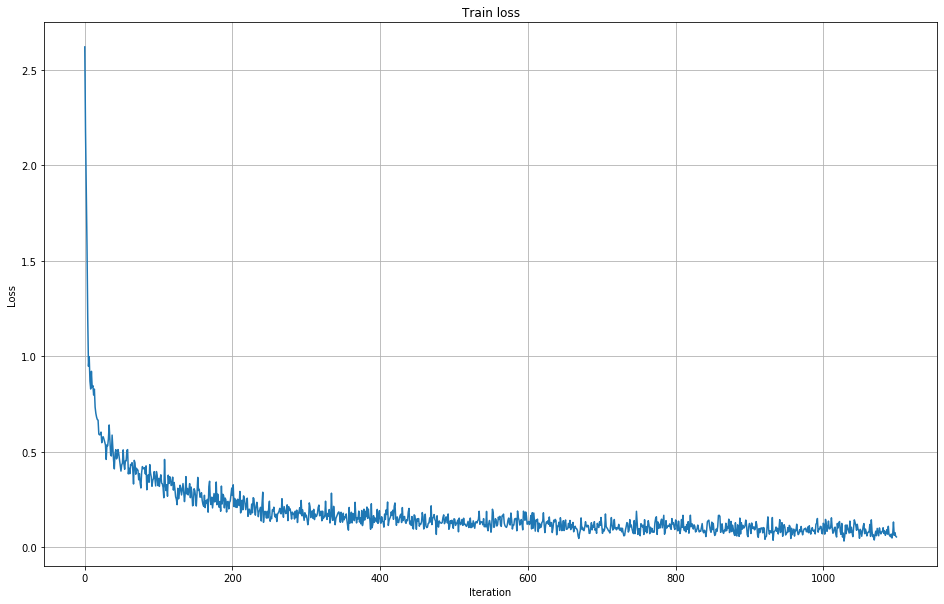

In [68]:
plt.figure(figsize=(16, 10))
plt.title('Train loss')
plt.plot(result['losses']['train'])
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss');

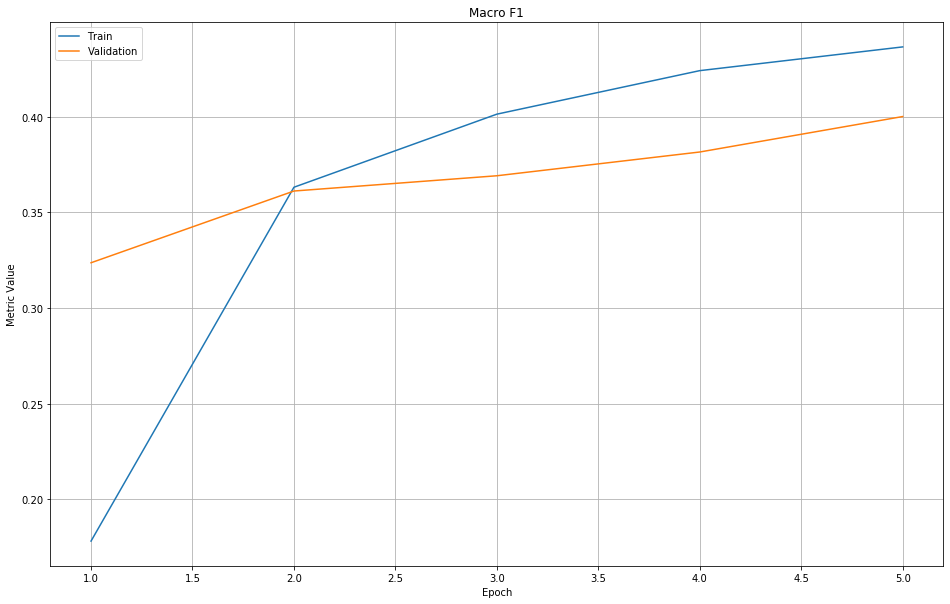

In [69]:
plt.figure(figsize=(16, 10))
plt.title('Macro F1')
epochs = np.arange(1, len(result['micro_f1']['valid']) + 1)
plt.plot(epochs, result['macro_f1']['train'], label='Train')
plt.plot(epochs, result['macro_f1']['valid'], label='Validation')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Metric Value');

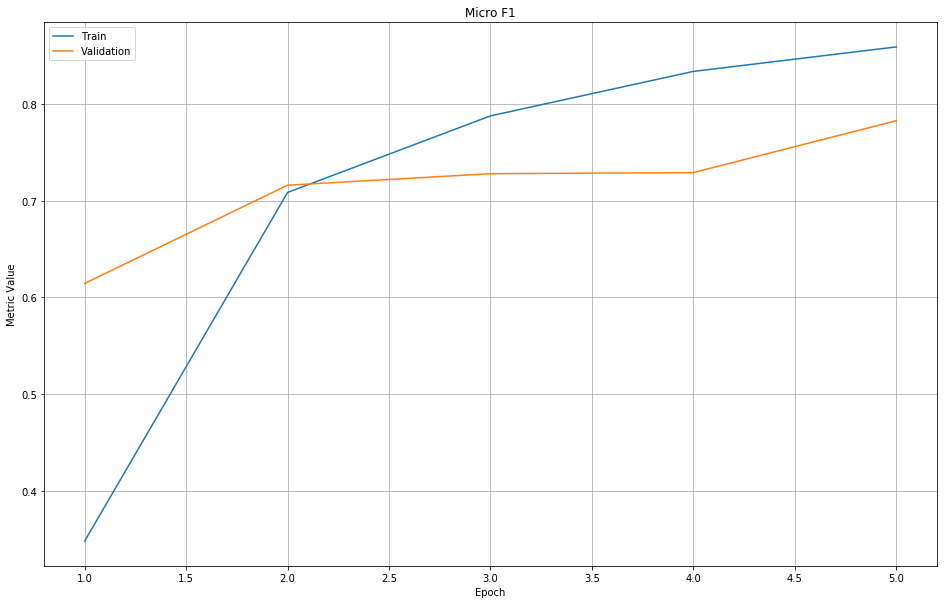

In [70]:
plt.figure(figsize=(16, 10))
plt.title('Micro F1')
epochs = np.arange(1, len(result['micro_f1']['valid']) + 1)
plt.plot(epochs, result['micro_f1']['train'], label='Train')
plt.plot(epochs, result['micro_f1']['valid'], label='Validation')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Metric Value');

In [71]:
id_to_tag = {value: key for key, value in tag_to_id.items()}

In [72]:
train_predicted_tags = list(map(lambda x: id_to_tag[x], result['predictions']['train']))
train_target_tags = list(map(lambda x: id_to_tag[x], result['tags']['train']))

valid_predicted_tags = list(map(lambda x: id_to_tag[x], result['predictions']['valid']))
valid_target_tags = list(map(lambda x: id_to_tag[x], result['tags']['valid']))

test_predicted_tags = list(map(lambda x: id_to_tag[x], result['predictions']['test']))
test_target_tags = list(map(lambda x: id_to_tag[x], result['tags']['test']))

In [75]:
print('Train Classificarion Report')
print(classification_report(train_target_tags, train_predicted_tags))

Train Classificarion Report
              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00        11
      B-MISC       0.00      0.00      0.00        35
       B-ORG       1.00      0.17      0.29        24
       I-LOC       0.90      0.89      0.90      8286
      I-MISC       0.92      0.82      0.87      4558
       I-ORG       0.90      0.84      0.87     10001
       I-PER       0.93      0.94      0.94     11124
           O       0.00      0.00      0.00         0

    accuracy                           0.88     34039
   macro avg       0.58      0.46      0.48     34039
weighted avg       0.91      0.88      0.90     34039



/Users/nbabakov/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nbabakov/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [76]:
print('Valid Classificarion Report')
print(classification_report(valid_target_tags, valid_predicted_tags))

Valid Classificarion Report
              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00         6
      B-MISC       0.00      0.00      0.00         9
       B-ORG       0.00      0.00      0.00         5
       I-LOC       0.82      0.79      0.80      1910
      I-MISC       0.88      0.73      0.80       909
       I-ORG       0.75      0.81      0.78      2487
       I-PER       0.88      0.80      0.84      2740
           O       0.00      0.00      0.00         0

    accuracy                           0.79      8066
   macro avg       0.42      0.39      0.40      8066
weighted avg       0.83      0.79      0.80      8066



In [77]:
print('Test Classificarion Report')
print(classification_report(test_target_tags, test_predicted_tags))

Test Classificarion Report
              precision    recall  f1-score   support

      B-MISC       0.00      0.00      0.00         4
       I-LOC       0.88      0.82      0.85      2094
      I-MISC       0.95      0.75      0.84      1262
       I-ORG       0.75      0.84      0.79      2092
       I-PER       0.91      0.85      0.88      3085
           O       0.00      0.00      0.00         0

    accuracy                           0.82      8537
   macro avg       0.58      0.54      0.56      8537
weighted avg       0.87      0.82      0.84      8537



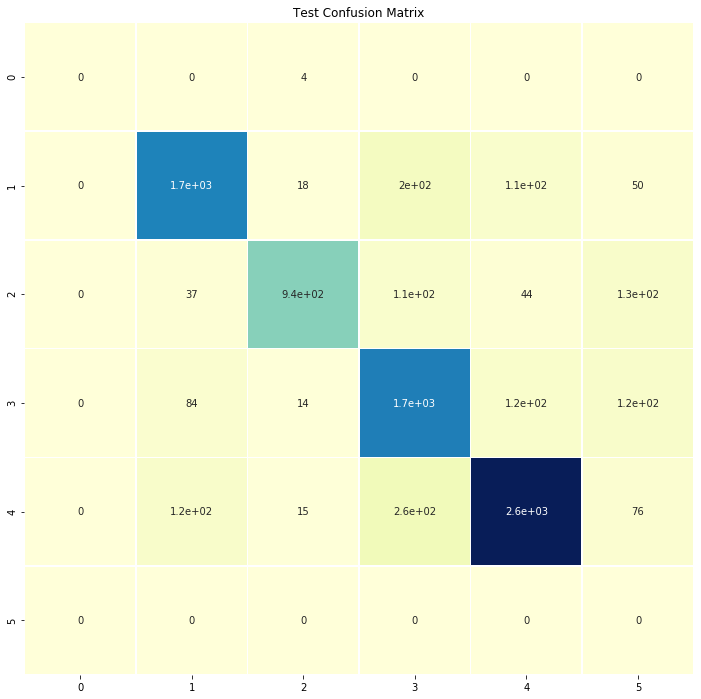

In [89]:
plt.figure(figsize=(12, 12))
plt.title('Test Confusion Matrix')
train_cm = confusion_matrix(test_target_tags, test_predicted_tags)
sns.heatmap(train_cm, annot=True, linewidths=.5, cmap='YlGnBu', cbar=False)